# <center>ASTR4004/8004 - Inference - Part 6</center> 

## Simulation-based inference

Our goal is to perform inference on a model's parameters $\theta$ given observations $D$ and learn the posterior distribution $P(\theta|D)$. Normally, we do this with Bayes' rule:
$$
P(\theta|D)=P(D|\theta)\frac{P(\theta)}{P(D)},
$$
which relies on the likelihood function $P(D|\theta)$.

<font color='red'> However, what if we don't know the likelihood or there is no functional form to evaluate the likelihood?</font>

You can train a classifier $\tilde{P}(y = 1 \mid \theta, D)$ to distinguish whether the sample $(\theta, D)$ is drawn jointly $(y=1)$ or marginally $(y=0)$. The classifier will inform the likelihood-to-evidence ratio.

$$
\frac{P(D|\theta)}{P(D)} = \frac{P(\theta|D)}{P(\theta)} =  
\frac{P(\theta, D)}{P(\theta)P(D)}
\equiv 
\frac{\tilde{P}(\theta, D \mid y = 1)}{\tilde{P}(\theta, D \mid y = 0)} 
= 
\frac{\tilde{P}(\theta, D, y = 1)}{\tilde{P}(\theta, D, y = 0)} 
= 
\frac{\tilde{P}(y = 1 \mid \theta, D)}{\tilde{P}(y = 0 \mid \theta, D)} 
= 
\frac{\tilde{P}(y = 1 \mid \theta, D)}{1 - \tilde{P}(y = 1 \mid \theta, D)}
$$

This notebook shows a simple example of model recovery using `swyft` and its backend PyTorch (`torch`).

## Useful packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import swyft

ERROR:tornado.general:Uncaught exception in ZMQStream callback
Traceback (most recent call last):
  File "/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/traitlets/traitlets.py", line 632, in get
    value = obj._trait_values[self.name]
KeyError: '_control_lock'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/zmq/eventloop/zmqstream.py", line 565, in _log_error
    f.result()
  File "/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 301, in dispatch_control
    async with self._control_lock:
  File "/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/traitlets/traitlets.py", line 687, in __get__
    return t.cast(G, self.get(obj, cls))  # the G should encode the Optional
  File "/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/traitlets/traitlets.py", line 649, i

## Load data and prepare the input and output pairs

In [2]:
data = np.loadtxt('../../data/samples_m_t.dat')
np.random.seed(0) # fix your seeds for reproducibility!
shuffle_index = np.random.permutation(len(data))
data = data[shuffle_index]

In this example, the first two columns correspond to dark matter mass in units of eV and lifetime in units of second, while the following are effective parameters characterizing the heating, ionization and excitation coefficients from dark matter to the intergalactic medium. In particular, the 2nd, 3rd, 4th and 5th columns can be used to compute the heating coefficient normalized by the lifetime as a function of redshift following a Schechter function.

/var/folders/fm/tnz6mdf51p11wf9c411b1_kr0000gp/T/ipykernel_16963/1230117049.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc=0)


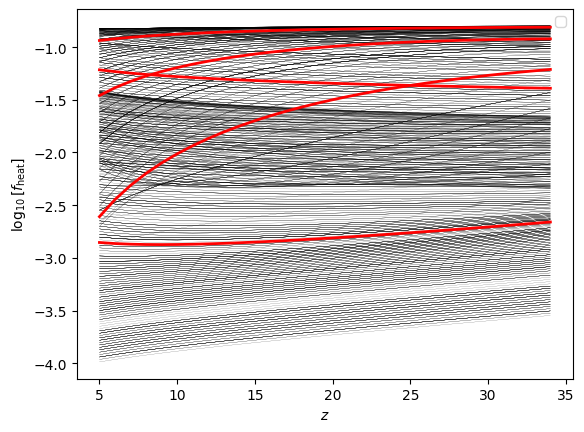

In [3]:
# identify input parameters and output observables (i.e., fheat)
params = np.log10(data[:,0]).reshape([-1,1])

zs = np.arange(5, 35)
fheat = data[:,2]+np.log10(data[:,1]) + np.log10(np.exp(data[:,3]*(zs[:,None]-15)) * ((zs[:,None])/15)**data[:,4])
fheat = fheat.T

# We keep the first 5 samples as observations (amortization!), and use the rest for training
obs = swyft.Samples(fheat = fheat[:5], logm = params[:5])
samples = swyft.Samples(fheat = fheat[5:], logm = params[5:])

# let's visualize the dataset
for i in range(1000):
    plt.plot(zs, samples[i]['fheat'], color='k', lw=0.1)

for i in range(5):
    plt.plot(zs, obs[i]['fheat'], color='r', lw = 2)
    
plt.ylabel(r"$\log_{10}\left[f_{\rm heat}\right]$")
plt.xlabel(r"$z$")
plt.legend(loc=0)

We could also take a look at the joint and marginal samples to get a feeling for the classification that will happen.

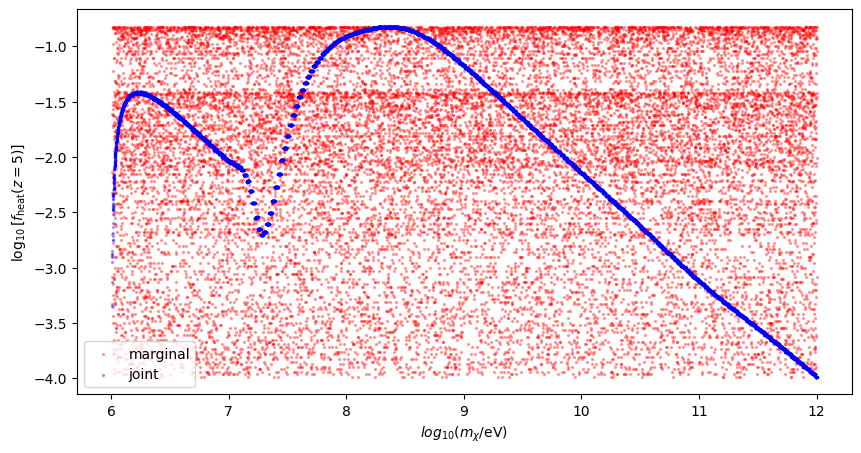

In [4]:
idx_arr = np.linspace(0, len(params) - 1, len(params), dtype=np.int32)
np.random.shuffle(idx_arr)
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot(1, 1, 1)
plt.scatter(params[idx_arr], fheat[:, 0], alpha=0.3, c='r', s=2., label='marginal')
plt.scatter(params, fheat[:, 0], alpha=0.3, c='b', s=2., label='joint');
plt.xlabel(r'$log_{10}(m_{\chi}/ {\rm eV})$')
plt.ylabel(r"$\log_{10}\left[f_{\rm heat}(z=5)\right]$")
plt.legend()

## Inference network

Swyft comes with a few default networks. Here we use swyft.LogRatioEstimator_1dim, which is a dense network that estimates one-dimensional posteriors. You can use LogRatioEstimator_Ndim to estimate higher-dimensional marginalized posteriors.

In [5]:
class Network(swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = len(zs), num_params = 1, varnames = 'logm')

    def forward(self, data, theta):
        logratios = self.logratios1(data['fheat'], theta['logm'])
        return logratios

## Training
Training is now done using the SwyftTrainer class.

In [6]:
model = swyft.SwyftTrainer(precision = 64)
network = Network()
model.fit(network, swyft.SwyftDataModule(samples))

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint

  | Name       | Type                   | Params
------------------------------------------------------
0 | logratios1 | LogRatioEstimator_1dim | 19.3 K
------------------------------------------------------


Sanity Checking: 0it [00:00, ?it/s]

/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/torch/__init__.py:1264: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/tensor/python_tensor.cpp:436.)
  _C._set_default_tensor_type(t)
/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Reloading best model: /Users/yqin/Library/CloudStorage/OneDrive-AustralianNationalUniversity/Documents/Academic_Stuff/ANU/RSAA/Teaching/ASTR4004_8004/2025/astr4004-8004-2025/notebooks/answers/lightning_logs/version_30/checkpoints/epoch=22-step=11408.ckpt


## Inference

Since the inference network estimates the logarithm of the posterior-to-prior ratio, we can obtain weighted posterior samples by running many prior samples through the inference network. To this end, we first generate prior samples.

In [7]:
logm_min = 6
logm_max = 12
prior = np.random.rand(100000, 1)
prior = prior * (logm_max - logm_min) + logm_min

prior_samples = swyft.Samples(logm = prior)

Then we evaluate the inference network by using the infer method of the swyft.Trainer object.

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 496it [00:00, ?it/s]

/Users/yqin/virtualenvs/astr4004_8004/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/prediction_epoch_loop.py:173: UserWarning: Lightning couldn't infer the indices fetched for your dataloader.
  warning_cache.warn("Lightning couldn't infer the indices fetched for your dataloader.")
The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 496it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 496it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 496it [00:00, ?it/s]

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: EarlyStopping, ModelCheckpoint


Predicting: 496it [00:00, ?it/s]

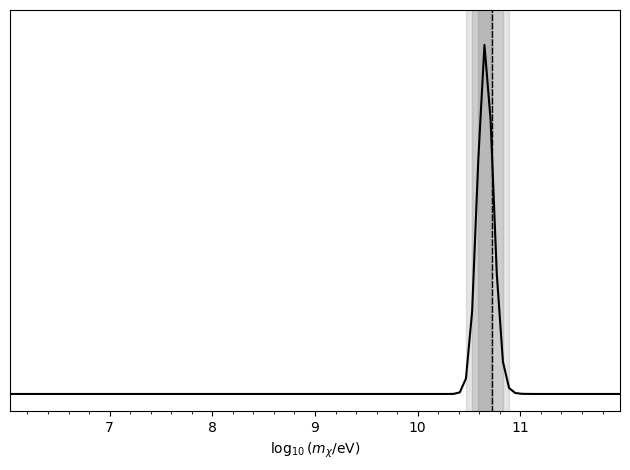

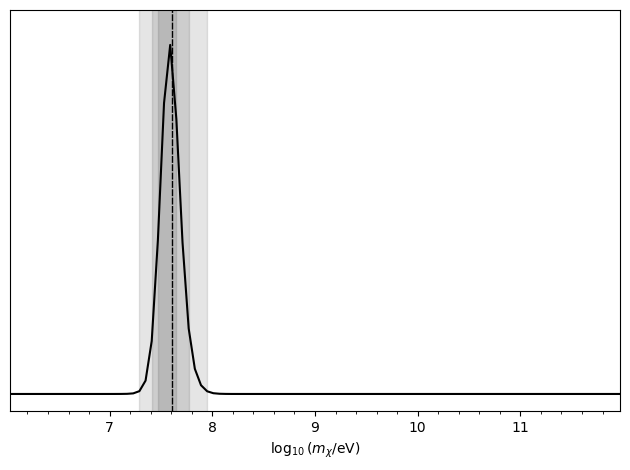

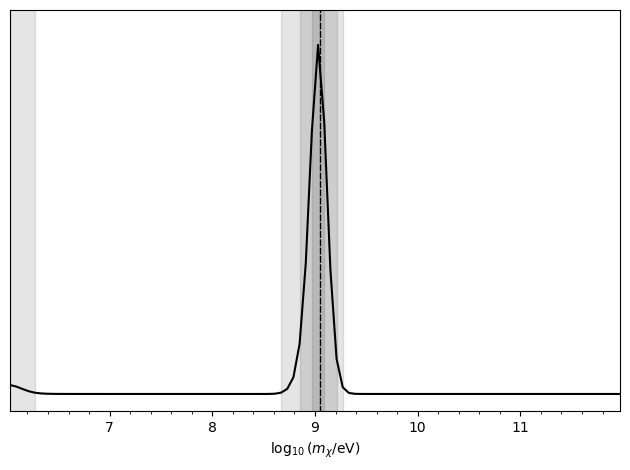

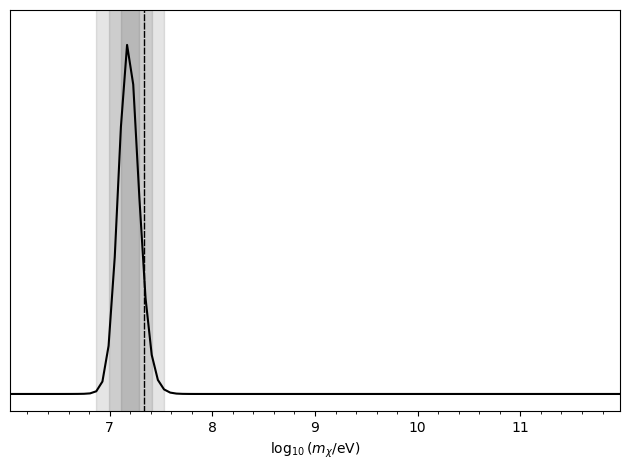

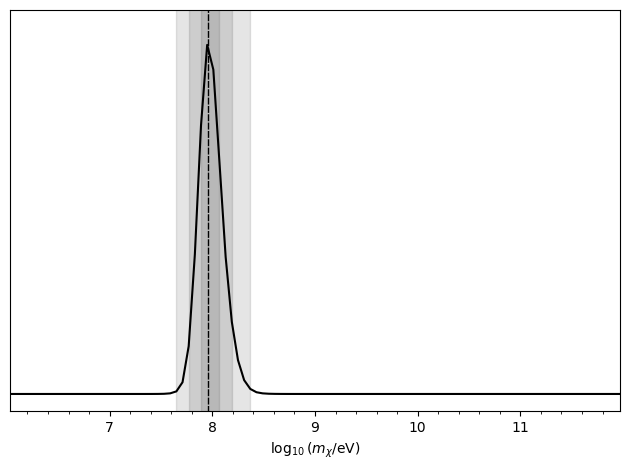

In [8]:
for i in range(5):
    predictions = model.infer(network, obs[i], prior_samples)
    swyft.plot_posterior(predictions, "logm[0]", truth={'logm[0]':obs[i]['logm']}, 
                    labels = [r'$\log_{10}(m_{\chi}/{\rm eV})$',]);

## Converage tests

How do we know if we are getting it right?

If the obtained posterior is accurate, we expect the true parameters to fall outside the p=95% highest posterior density region in only 1-p=5% of the cases. If the chance goes above 5%, the posterior is narrower than it should be and hence overconfident; If the chance is lower than 5%, the posterior is wider than the truth and hence conservative.

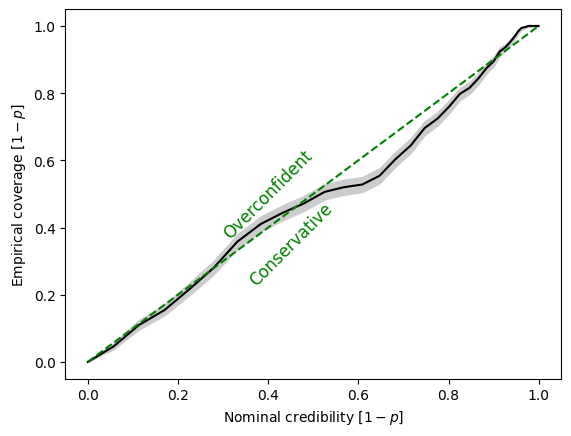

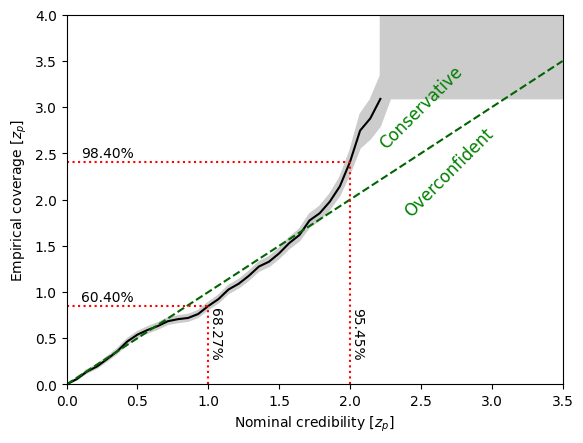

In [30]:
coverage_samples = model.test_coverage(network, samples[-500:], prior_samples)

# The pp figure plots 1-p vs 1-p
swyft.plot_pp(coverage_samples, "logm[0]")
plt.text(0.4, 0.5, "Overconfident", rotation=45,
        color="green", fontsize=12, ha="center", va="center")

plt.text(0.45, 0.35, "Conservative", rotation=45,
        color="green", fontsize=12, ha="center", va="center")

plt.show()

# The zz figure plots "sigma" vs "sigma" as z is defined as 1-0.5*(1-p)
swyft.plot_zz(coverage_samples, "logm[0]")
plt.text(2.5, 3, "Conservative", rotation=45,
        color="green", fontsize=12, ha="center", va="center")

plt.text(2.7, 2.3, "Overconfident", rotation=45,
        color="green", fontsize=12, ha="center", va="center");